# An analysis of WTA data

We use WTA (Women's Tennis Association) data (collected from the [WTA](https://www.wtatennis.com/) website by [Jeff Sackmann](https://github.com/JeffSackmann/tennis_wta) to carry out an exploration of players and matches over the course of 2023. We use `Scikit-Learn` to build a Logistic Regression classifier to predict match outcomes, with the help of `pandas`, `matplotlib`, `numpy` and `sns` for data processing and visualisation. We will also look into exploratory questions such as:
1. How has the number of professional women tennis players changed across the time period covered by the dataset (1848-2023)?
2. Which countries are most heavily represented by these players?
3. Who have been the most successful players in 2023 and how successful have they been?
4. How much movement has there been in the rankings over 2023: have the top 5 at the start of 2023 managed to maintain their rankings?
5. Comeback analysis: How often do players come back from a set down to win, and who are the biggest comeback queens of the year? 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import re
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

## Players

The first dataset we will look at is `players.csv`. We'll import it then look at the columns and data types that we have.

In [3]:
players = pd.read_csv('wta_players.csv', engine = 'python', index_col=0)
players.dtypes

name_first      object
name_last       object
hand            object
dob            float64
ioc             object
height         float64
wikidata_id     object
dtype: object

The dob column is currently a float; we will convert this to date format.

In [4]:
# Define a function to convert date
def convert_to_date(date_str):
    try:
        return pd.to_datetime(date_str, format='%Y%m%d')
    except ValueError:
        return pd.NaT 

# apply function to dob column
players['dob'] = players['dob'].apply(convert_to_date)


We will check for missing values.

In [5]:
players.isna().sum()

name_first      3908
name_last          0
hand               3
dob            40868
ioc             1051
height         65292
wikidata_id    62924
dtype: int64

There are some columns with very many missing values. All rows have a value in name_last. Since all rows have at least a last name, we will keep all rows of the dataset. 

### 1. How do the number of players change across time?

To track how the players are distributed across the time frame, we'll plot their DOBs in a density plot.


<Axes: title={'center': 'WTA Player Year of Birth'}, xlabel='dob'>

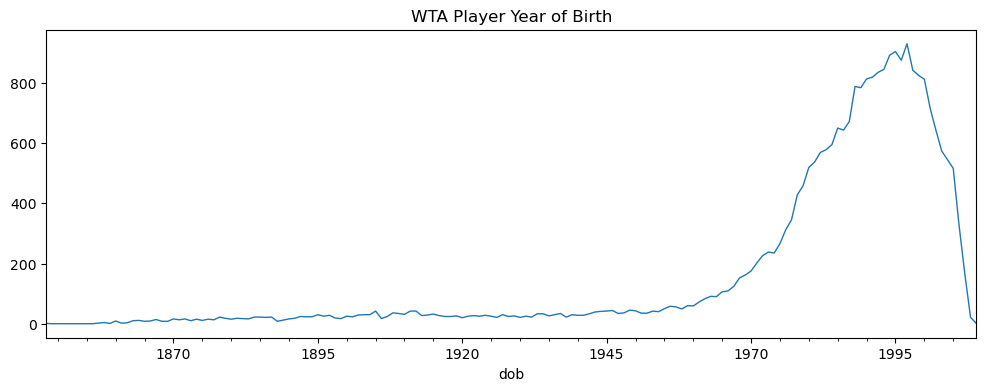

In [6]:
players.set_index('dob').resample('YE').count().ioc.plot.line(
    linewidth=1, 
    figsize=(12, 4),
    title='WTA Player Year of Birth'
)

In [7]:
players90 = players.set_index('dob').resample('YE').count().loc['1990-01-01':'1999-01-01', 'name_last'].sum()
players90

7755

We can see how the number of players has increased substantially across the 20th century, with 7755 players born in the 90s.

### 2. Which countries do these players represent?

In [8]:
# Group by country and count how many represent each country
country_count = players.groupby(['ioc']).size().reset_index(name = 'N').drop(0)

# Put this in a chloropleth map
fig = px.choropleth(
    data_frame=country_count,
    locations='ioc',          # Column with country names or ISO-3 codes
    locationmode='ISO-3', # Use 'ISO-3' if using ISO-3 codes
    color='N',          # Column with values to represent
    hover_name='ioc',         # Column to display in hover information
    range_color=(0, 2000),
    color_continuous_scale='Blues'# Label for the color bar
)

fig.update_layout(
    title='Number of Players from Each Country',
    geo=dict(
        showframe=False,
        showcoastlines=False,
        projection_type='equirectangular'
    )
)

# Show the plot
fig.show()

We can see that Europe (particularly Great Britain), the United States and Australia are particularly well represented. Africa is much more sparsely represented.

## Matches

This dataset has information about matches played in tournaments taking place in 2023. We have information about the tournament, players (e.g. name, height, ranking, seed, age) and the match (e.g. number of aces, double faults, serve statistics, break points saved and won.)

In [9]:
matches = pd.read_csv('wta_matches_2023.csv')
print(list(matches.columns))
matches.head()

['tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level', 'tourney_date', 'match_num', 'winner_id', 'winner_seed', 'winner_entry', 'winner_name', 'winner_hand', 'winner_ht', 'winner_ioc', 'winner_age', 'loser_id', 'loser_seed', 'loser_entry', 'loser_name', 'loser_hand', 'loser_ht', 'loser_ioc', 'loser_age', 'score', 'best_of', 'round', 'minutes', 'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon', 'w_SvGms', 'w_bpSaved', 'w_bpFaced', 'l_ace', 'l_df', 'l_svpt', 'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced', 'winner_rank', 'winner_rank_points', 'loser_rank', 'loser_rank_points']


,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
0,2023-9900,United Cup,Hard,18,I,20230102,298,202468,NaN,NaN,...,43.0,20.0,12.0,9.0,3.0,9.0,3.0,4691.0,27.0,1528.0
1,2023-9900,United Cup,Hard,18,I,20230102,297,201619,NaN,NaN,...,32.0,14.0,6.0,8.0,5.0,11.0,11.0,2417.0,54.0,951.0
2,2023-9900,United Cup,Hard,18,I,20230102,294,202468,NaN,NaN,...,26.0,10.0,5.0,8.0,2.0,7.0,3.0,4691.0,1.0,11085.0
3,2023-9900,United Cup,Hard,18,I,20230102,293,201619,NaN,NaN,...,47.0,29.0,5.0,9.0,4.0,8.0,11.0,2417.0,48.0,1030.0
4,2023-9900,United Cup,Hard,18,I,20230102,290,203354,NaN,NaN,...,53.0,37.0,22.0,17.0,2.0,9.0,27.0,1528.0,6.0,3871.0


### 3. Who was the most successful in 2023?

Let's see who won the highest proportion of their matches in 2023. We'll only include those who played at least 10 matches.

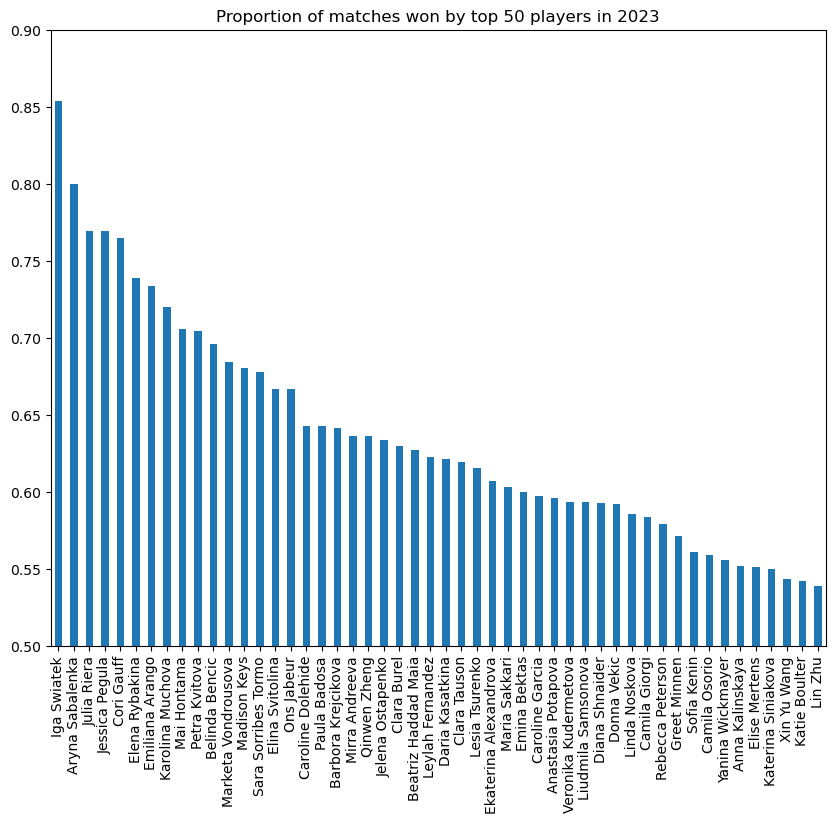

In [10]:
# Count how many matches each player has won and lost.
winners = matches.groupby('winner_name').winner_name.count()
losers = matches.groupby('loser_name').loser_name.count()

# Merge winners and losers data frames
player_success = pd.concat([winners, losers], axis = 1).fillna(0).rename(columns = {'winner_name':'wins',
                                                                                    'loser_name':'losses'})

# calculate win rates of each player
player_success['win_rate'] = player_success['wins'].div(player_success.sum(axis = 1))

# filter for players who played at least 10 matches
player_success_filtered = player_success[player_success[['wins', 'losses']].sum(axis = 1) >= 10]

# Plot most successful players and their success rates
fig, ax = plt.subplots(figsize=(10,8))
player_success_filtered.win_rate.sort_values(ascending=False).head(50).plot.bar(ax = ax)
# Set y-axis range and title
ax.set_ylim(0.5, 0.9)
ax.set_title("Proportion of matches won by top 50 players in 2023")
plt.show()


Iga Swiatek has won the highest proportion of matches in 2023, with a win rate of 85%.

### 4. How much movement has there been amongst the top 5 of January 2023? Have they managed to maintain their level throughout the year?

In [11]:
# convert tournament date column to date format
matches.tourney_date = pd.to_datetime(matches.tourney_date, format='%Y%m%d')

# sort by tournament date to find first tournament of the year
matches = matches.sort_values(by = 'tourney_date')

# extract first tournament
# there are actually several tournaments at this date, but for these purposes that doesn't matter
first_tourney = matches[matches['tourney_date'] == matches.iloc[0]['tourney_date']]

# pull out players ranked 1-5 at this timepoint
first_tourney_top5 = first_tourney[first_tourney['winner_rank'] <= 5][['winner_name', 'winner_rank']].drop_duplicates().sort_values('winner_rank')

# check if all 5 won at least once in first tournament, this should be True
print(first_tourney_top5.shape[0] == 5)

top5_jan23 = first_tourney_top5['winner_name']

True


Now we can track the points gained/lost by these played throughout the year.

(array([19358., 19389., 19417., 19448., 19478., 19509., 19539., 19570.,
        19601., 19631., 19662.]),
 [Text(19358.0, 0, '2023-01'),
  Text(19389.0, 0, '2023-02'),
  Text(19417.0, 0, '2023-03'),
  Text(19448.0, 0, '2023-04'),
  Text(19478.0, 0, '2023-05'),
  Text(19509.0, 0, '2023-06'),
  Text(19539.0, 0, '2023-07'),
  Text(19570.0, 0, '2023-08'),
  Text(19601.0, 0, '2023-09'),
  Text(19631.0, 0, '2023-10'),
  Text(19662.0, 0, '2023-11')])

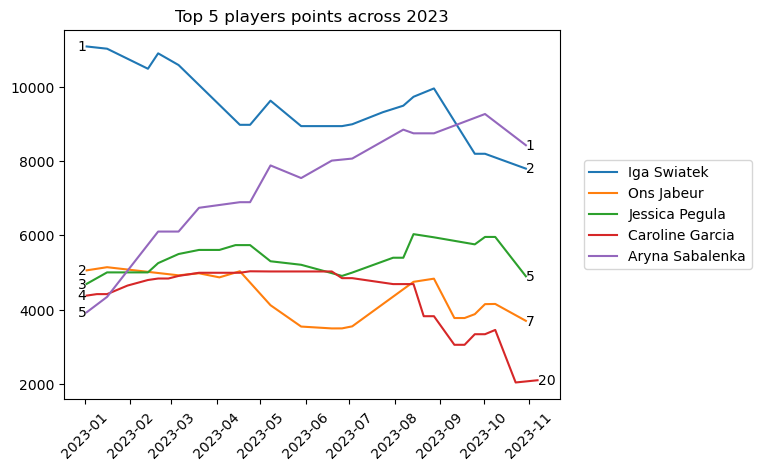

In [24]:
ranking_points_list = []

for player in top5_jan23:
    # track points for given player
    ranking_points = matches[(matches['winner_name'] == player) | (matches['loser_name'] == player)][['winner_name', 'loser_name', 'tourney_date', 'winner_rank_points',
                                                                                                               'loser_rank_points', 'winner_rank', 'loser_rank']]

    # pull out points and rank from appropriate winner or loser column
    ranking_points['points'] = np.where(ranking_points['winner_name'] == player, ranking_points['winner_rank_points'], ranking_points['loser_rank_points'])
    ranking_points['rank'] = np.where(ranking_points['winner_name'] == player, ranking_points['winner_rank'], ranking_points['loser_rank'])

    # Drop 'winner_rank_points' and 'loser_rank_points' columns
    ranking_points = ranking_points.drop(['winner_rank_points', 'loser_rank_points', 'winner_rank', 'loser_rank'], axis=1)

    # add column with player name
    ranking_points['player'] = player

    # append to list
    ranking_points_list.append(ranking_points)


# Make plot
for player_df in ranking_points_list:

    # Player's year begin rank
    start_date = player_df['tourney_date'].iloc[0]
    start_point = player_df['points'].iloc[0]
    start_rank = player_df['rank'].iloc[0]

    # Find out the player's year end rank
    last_date = player_df['tourney_date'].iloc[-1]
    last_point = player_df['points'].iloc[-1]
    last_rank = player_df['rank'].iloc[-1]

    # Plot the ranking points against tourney_date for the current player, with their year end ranking added as text
    plt.plot(player_df['tourney_date'], player_df['points'], label=player_df['player'].iloc[0])
    plt.text(start_date, start_point, round(start_rank) , ha = 'right', va = 'center')
    plt.text(last_date, last_point, round(last_rank) , ha = 'left', va = 'center')

plt.legend(loc = "right",
           bbox_to_anchor=(1.4, 0.5))
plt.title("Top 5 players points across 2023")
plt.xticks(rotation=45)


Aryna Sabalenka has had a very successful year, moving from 5th at the start of the year to finish at number 1, ending Iga Swiatek's reign. All other top 5 players ranking's dropped, with only Jessica Pegula remaining in the top 5. Ons Jabeur fell to 7th and Caroline Garcia ended the year ranked 20th. 

### 5. Comeback analysis

Who has had the most comebacks and how many have they had?

To find the matches that constitute comebacks, we need to clean the score column. The score is in the format `6-4 6-4`, but matches with a tiebreak take the form `6-4 6-7(4) 6-4`. First we'll remove the tiebreak score to just keep track of the games.

In [26]:
# function to remove any brackets and anything in the brackets
def clean_score(score):
    return re.sub(r'\(.*?\)', '', score)

# apply function to score
matches['cleaned_score'] = matches['score'].apply(lambda x: ' '.join(clean_score(set_score) for set_score in x.split()))
# now split into a list to separate the sets
matches['sets'] = matches['cleaned_score'].str.split()

Now we can identify the comeback matches with the following function:

In [27]:
def is_comeback(sets):
    if len(sets) > 2:
        try:
            # extract number of games won by the winner and loser in the first set
            first_set_winner_games, first_set_loser_games = map(int, sets[0].split('-'))
            # if the winner won less than the loser in the first set, they must have had a comeback
            if first_set_winner_games < first_set_loser_games:
                return True
        except ValueError:
            return False
    return False

# apply function to the sets column
matches['comeback'] = matches['sets'].apply(lambda x: is_comeback(x))

In [28]:
comeback_frequency = matches['comeback'].mean()
num_comebacks = matches['comeback'].sum()
total_matches = len(matches)

print(f"Comeback Frequency: {round(comeback_frequency, 3)}")
print(f"Number of Comebacks: {num_comebacks}")
print(f"Total Matches: {total_matches}")

Comeback Frequency: 0.165
Number of Comebacks: 465
Total Matches: 2810


So 16.5% of matches were comebacks: 465 out of 2810.

In [29]:
matches[matches.comeback == 1]['winner_name'].value_counts().head(1)

winner_name
Anastasia Potapova    11
Name: count, dtype: int64

Anastasia Potapova is the comeback queen, with 11 comebacks during the year.
What about as a proportion of their matches played?

In [30]:
# reshape data frame so all player names (winners and losers) are in one column, to be able to count total matches played
matches_long_player = pd.melt(matches,
                              id_vars = 'comeback',
                              value_vars = ['winner_name',
                                            'loser_name'],
                                var_name = "win",
                                value_name = "name")

# work out number of matches played, and number of comebacks
matches_comeback_prop = matches_long_player.groupby(['name']).agg(
    no_matches = ('name', 'size'),
    no_comeback = ('comeback', lambda x: (x[matches_long_player['win'] == 'winner_name']).sum())
).reset_index()

# calculate proportion of matches that are comebacks
matches_comeback_prop['comeback_prop'] = matches_comeback_prop['no_comeback'].div(matches_comeback_prop['no_matches'])
matches_comeback_prop.sort_values('comeback_prop', ascending = False, inplace = True)

Unsurprisingly, most of the players with the highest proportion of comebacks played very few (< 5 matches). The player with the highest comeback rate with > 5 matches was Caijsa Wilda Hennemann, with 3 out of 7 (42.9%), and the player with the highest comeback rate with > 10 matches was again Anastasia Potapova, with 11 out of 47 (23.4%). 

# Logistic Regression Classifier

### Prepare dataset

The aim is to build a logistic regression classifier predicting whether a match will be won or lost by various characteristics of the match, such as number of aces, double faults, 1st serves in, break points won etc. Currently, each match has one row in the dataframe. In order to have our outcome variable, which is win vs. loss, as a column, we need to convert the dataframe to a long format with the feature variables and target variable as distint columns. 

In [31]:
# convert to long format 
matches_long = pd.melt(matches.reset_index(),
                       id_vars = 'index',
                       value_vars = ['w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon',
                                     'w_SvGms', 'w_bpSaved', 'w_bpFaced', 'l_ace', 'l_df', 'l_svpt',
                                     'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced'],
                       var_name = 'variable',
                       value_name = 'count')

# Extract 'win' and 'stat' from 'variable' column
matches_long[['win', 'stat']] = matches_long['variable'].str.extract(r'([wl])_(.*)')
matches_long['win'] = matches_long['win'].map({'w': 1, 'l': 0})  # Convert 'w' to 1 and 'l' to 0

# Drop the original 'variable' column
matches_long = matches_long.drop(columns='variable')

# Pivot to have separate columns for each of the stats
# Need to alter the index of the losing matches to keep separate rows for win and lose
N = len(matches)
matches_long.loc[matches_long['win'] == 0,'index'] += N
matches_wide = matches_long.pivot(index=['index', 'win'], columns='stat', values='count').reset_index().dropna()


### Define feature and target variables

In [32]:
feature_cols = [col for col in matches_wide.columns if col not in ['index', 'win']]
X = matches_wide[feature_cols]
y = matches_wide.win

# Check for missing values: there are none
matches_wide.isna().sum().sum() == 0

True

### Split data into training and test set

We'll break the dataset into training (75%) and test (25%) datasets so that we can evaluate the model performance on data not used to build the model.

In [33]:
# split X and y into training and testing sets


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=16)

Look at distribution of feature variables in training dataset:

In [34]:
X_train.describe()

stat,1stIn,1stWon,2ndWon,SvGms,ace,bpFaced,bpSaved,df,svpt
count,3858.000000,3858.000000,3858.000000,3858.000000,3858.000000,3858.000000,3858.000000,3858.000000,3858.000000
mean,44.326594,28.139191,11.969155,10.644116,2.772421,8.005184,4.347330,3.629601,70.733281
std,15.731317,10.446653,5.370951,2.950036,2.877689,4.355117,3.129666,2.658202,22.575099
min,2.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,6.000000
25%,33.000000,21.000000,8.000000,8.000000,1.000000,5.000000,2.000000,2.000000,53.000000
50%,42.000000,27.000000,11.000000,10.000000,2.000000,8.000000,4.000000,3.000000,67.000000
75%,55.000000,35.000000,15.000000,13.000000,4.000000,11.000000,6.000000,5.000000,87.000000
max,111.000000,69.000000,40.000000,20.000000,21.000000,34.000000,27.000000,21.000000,149.000000


We have all numerical features so no need to encode any categorical variables. We will check the distribution of variables and look for any outliers.

### Check for distribution and outliers of features

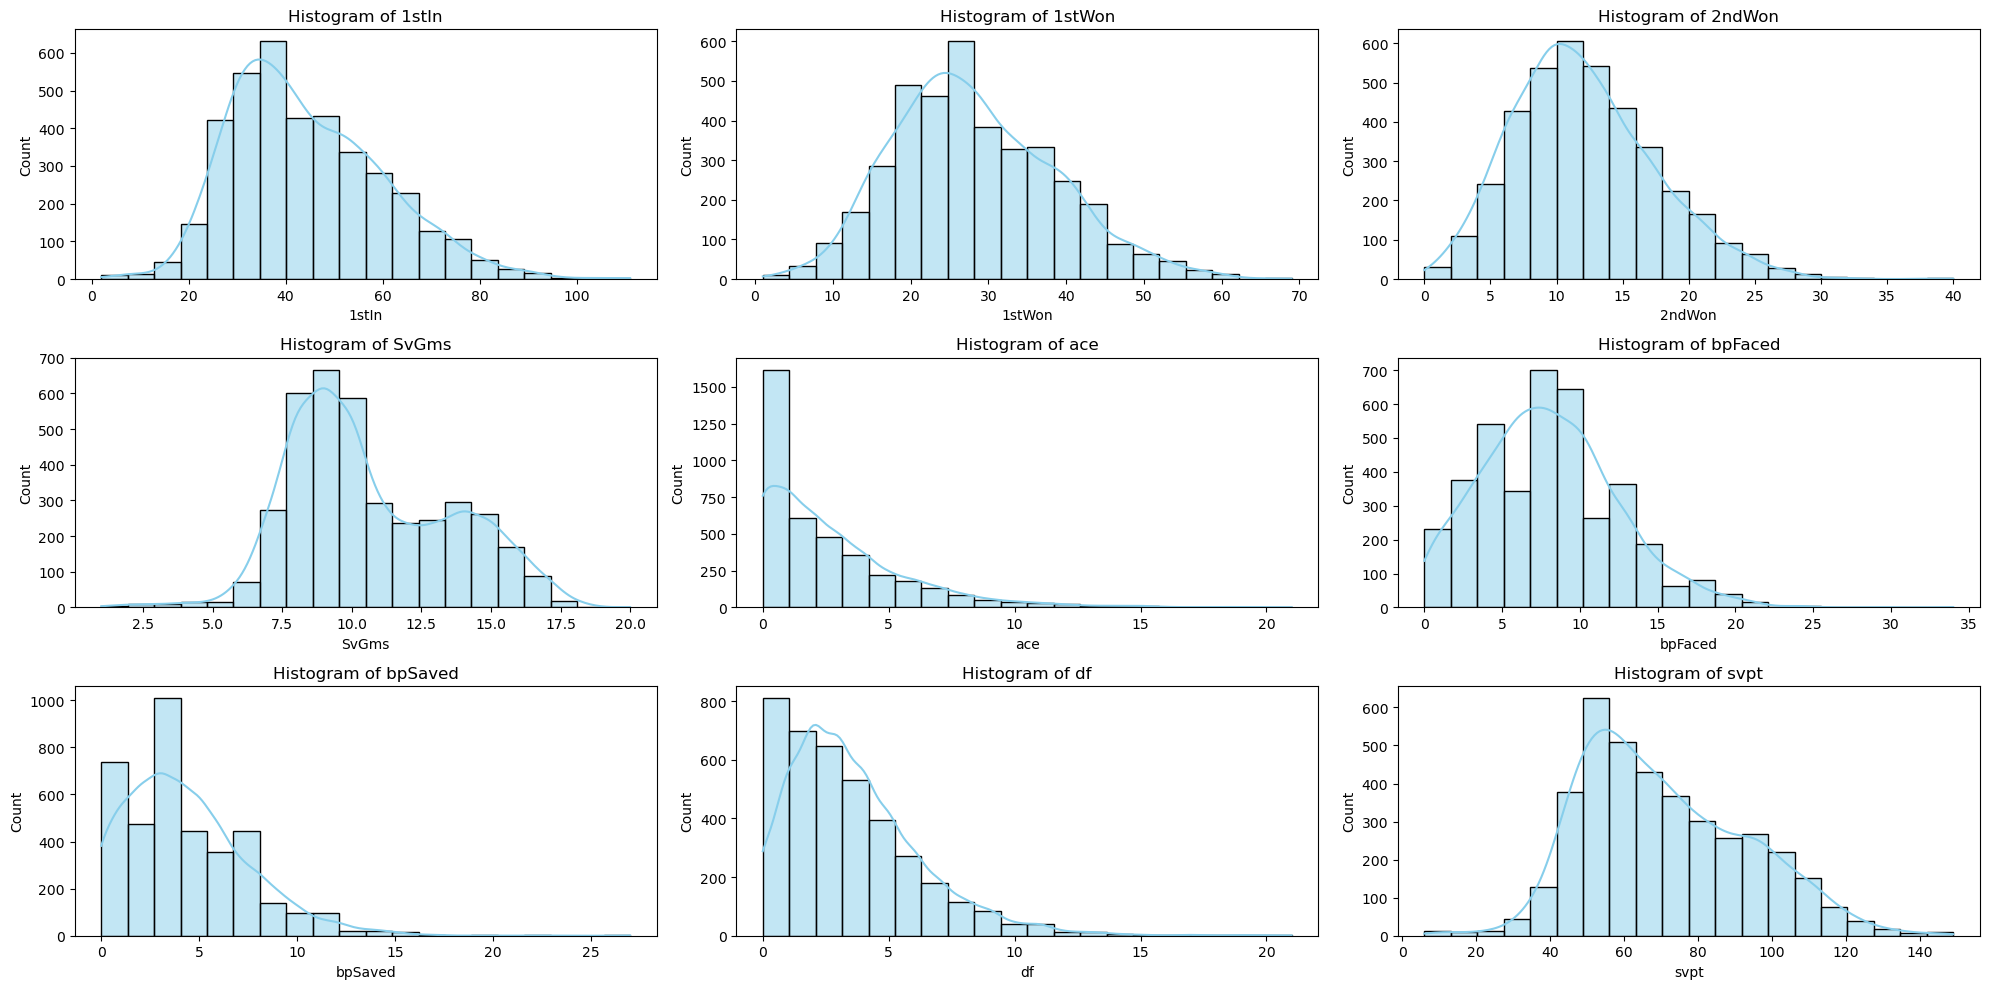

In [35]:
# Create a figure with subplots
fig, axes = plt.subplots(3, 3, figsize=(20, 10))

axes = axes.flatten()
# Loop through each variable to create a histogram
for i, var in enumerate(feature_cols):
    sns.histplot(X_train[var], bins=20, kde=True, ax=axes[i], color='skyblue')
    axes[i].set_title(f'Histogram of {var}')

plt.tight_layout()
plt.show()

There don't appear to be any extreme outliers that need to be removed or capped.

We can now create a set of plots to visualise the relationship between each feature and the target:

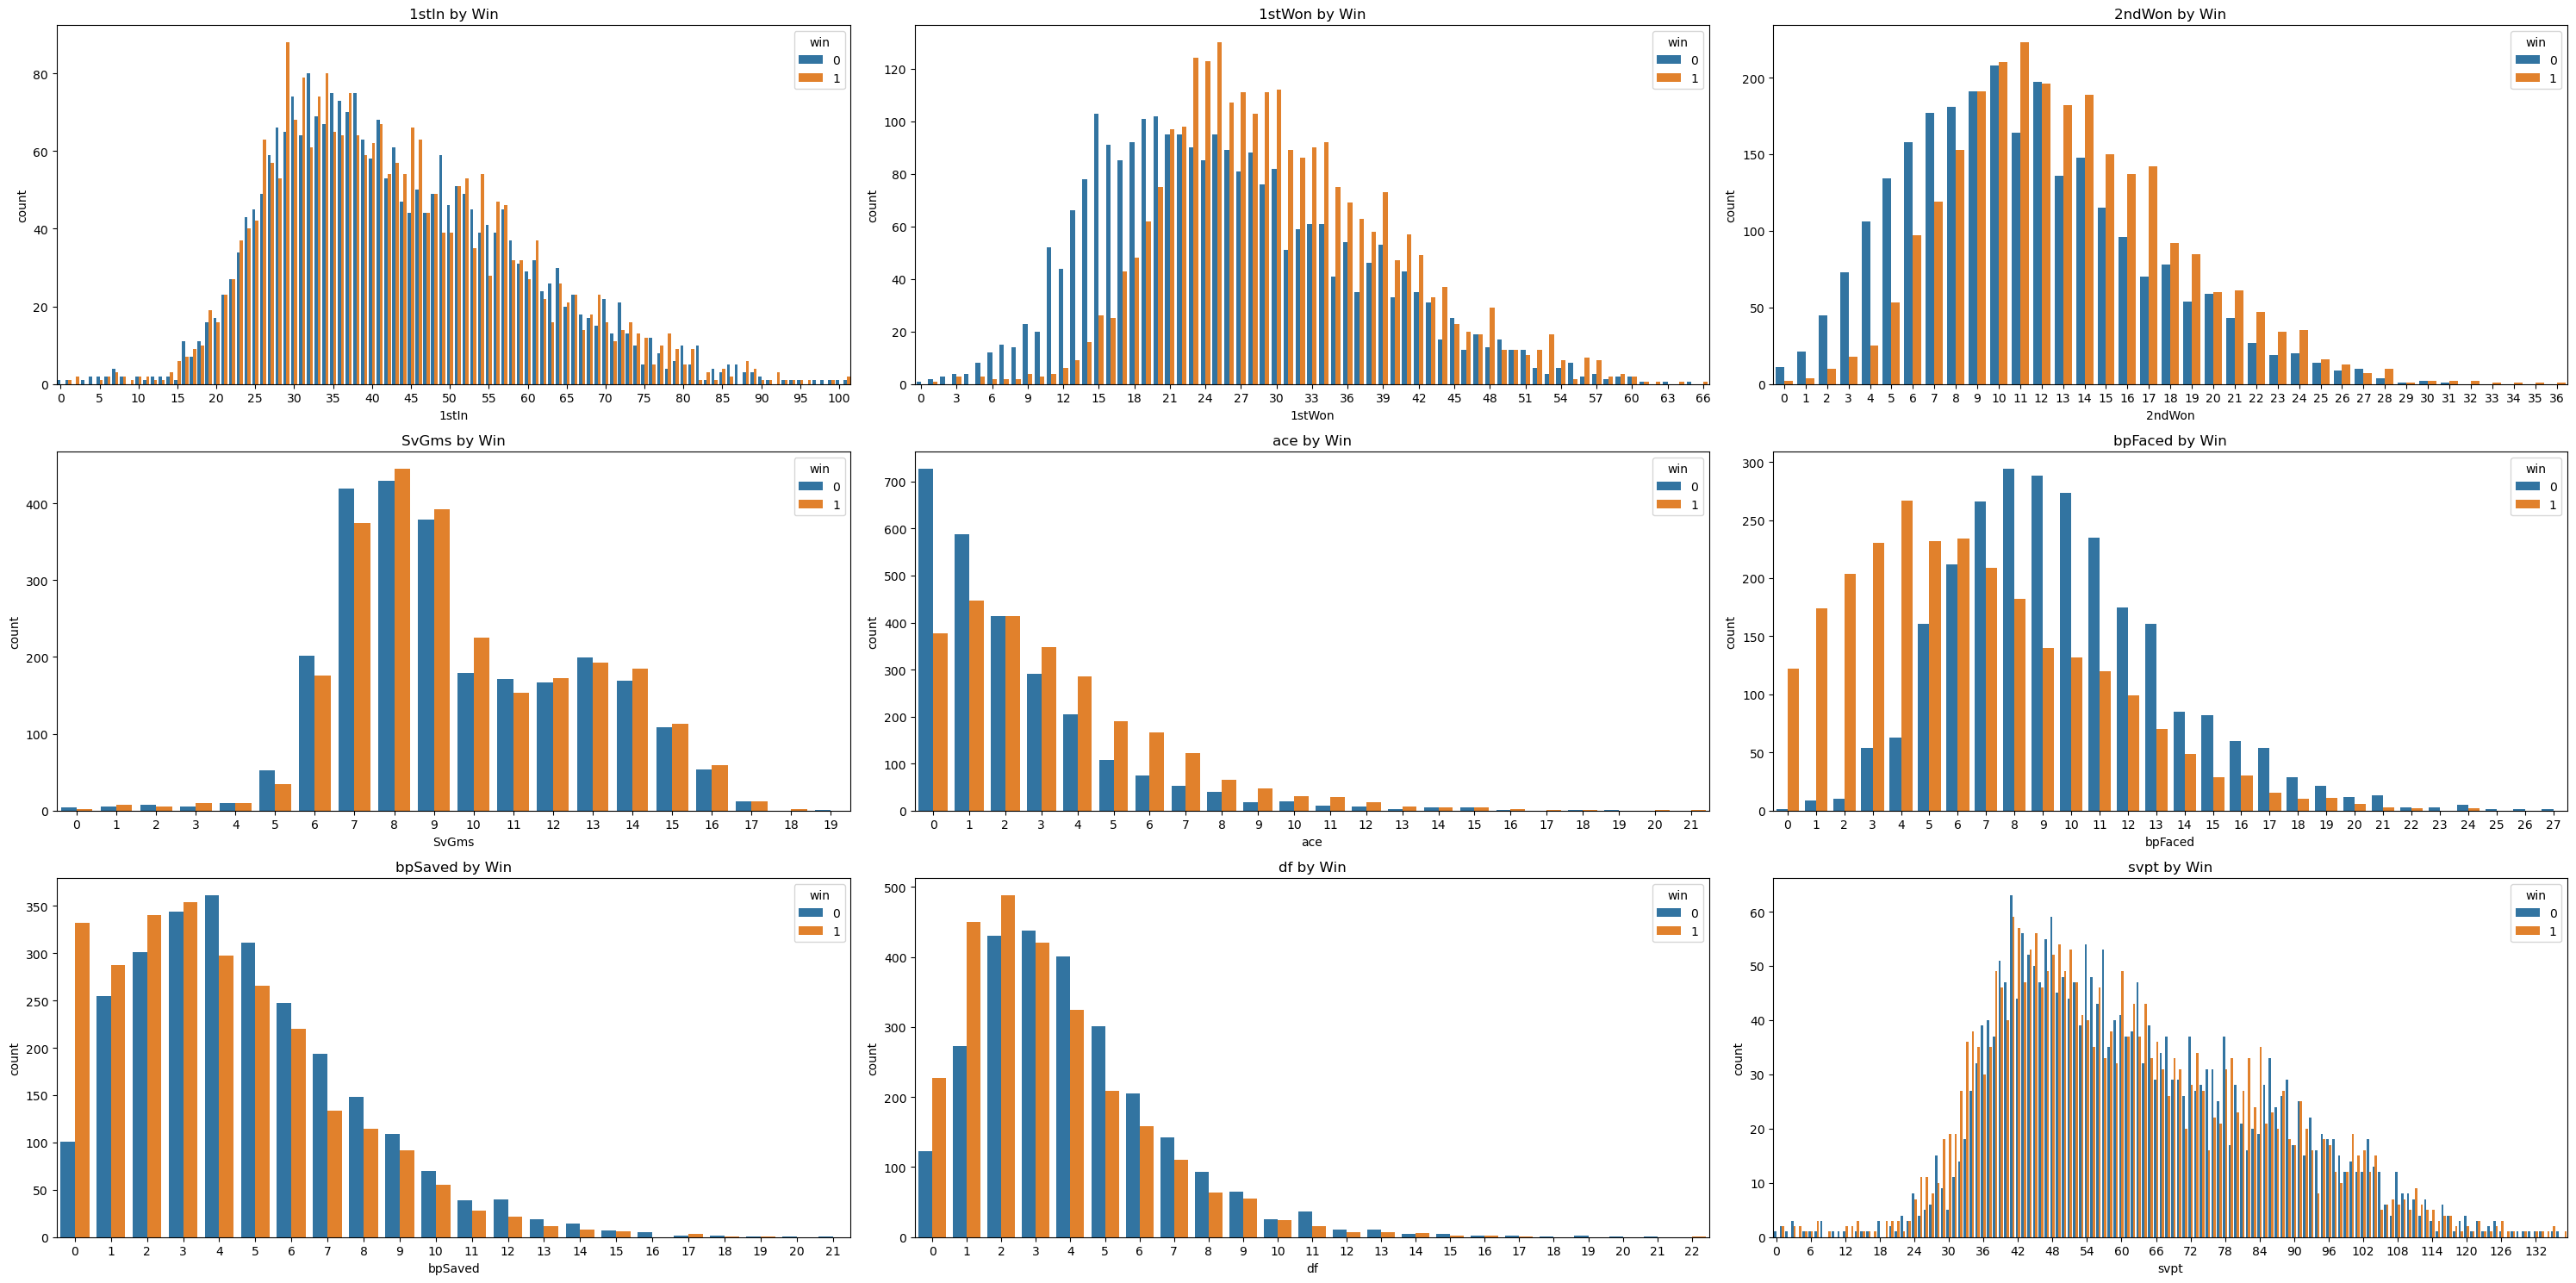

In [36]:

# Suppress UserWarnings
warnings.filterwarnings('ignore', category=UserWarning)

# Create a figure with subplots
fig, ax = plt.subplots(3, 3, figsize=(30, 15))

ax = ax.flatten()

# loop through features and plot bar chart grouped by 'win'
for i,var in enumerate(feature_cols):
    # define plot
    sns.countplot(data = matches_wide, x = var , hue = 'win', ax = ax[i])

    # to prevent ticks overlapping
    tick_positions = ax[i].get_xticks()
    
    # define step count according to how many ticks there are - with this spacing, make there be 20 tick labels
    step = len(ax[i].get_xticklabels())//20 
    ax[i].set_xticks(tick_positions[::step])
    ax[i].set_xticklabels([tick_positions[i] for i in range(0, len(tick_positions), step)])  # Update labels

    # Set title
    ax[i].set_title(f'{var} by Win')

plt.tight_layout()
plt.show()


We can see some unsurprising patterns here. Those who win serve more aces and fewer double faults. They face fewer break points, they are much more likely to save 0 break points but this makes sense in the context that they are much more likely not to face any break points to start with.

Now, before we proceed with model building, we will scale all the features to be on the same scale.


### Feature Scaling

Rescale the features to all be on the same scale.

In [37]:
cols = X_train.columns

scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train = pd.DataFrame(X_train, columns=[cols])
X_test = pd.DataFrame(X_test, columns=[cols])

### Model Training

X_train is now ready to be fed into the Logistic Regression Classifier. 

In [ ]:

# instantiate the model (using the default parameters)
logreg = LogisticRegression(random_state=16,
                            solver = "liblinear")

# fit the model with data
logreg.fit(X_train, y_train)

LogisticRegression(random_state=16, solver='liblinear')

### Check accuracy score

We can calculate the accuracy score: that is, the proportion of correctly predicted outcomes on the test dataset. We use the accuracy_score function from sklearn.metrics to compare the actual test set outcomes (y_test) with the model predictions (y_pred_test).

In [ ]:


# calculate the model predictions on the test set
y_pred_test = logreg.predict(X_test)

# calculate accuracy score
print('Model accuracy score: {0:0.4f}'. format(metrics.accuracy_score(y_test, y_pred_test)))

Model accuracy score: 0.7963


The model predicted the correct outcome 79.6% of the time on the test dataset.

## Compare train- and test- set accuracy

We can also check the accuracy on the training set. If the accuracy on the training set is considerably higher than the accuracy on the test set, this could be an indication of overfitting. 

In [ ]:
y_pred_train = logreg.predict(X_train)

print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))

Training-set accuracy score: 0.8053


Training set accuray is 80.5%. Training-set and test-set accuracies are comparable, so there is no indication of overfitting.

## Cross Validation

So far, we only tested the dataset once on one data set. To ensure this result isn't down to luck and provide a more robust estimate of model performance, we can use K-means cross validation, whereby we divide our sample into K groups. For each group, we fit a model on the remaining K-1 groups and evaluate the model on that group. We end up with K evaluations that can then be averaged to get an accurate estimate of model performance. 

In [ ]:


score = cross_val_score(logreg, X_train, y_train, cv = 10, scoring='accuracy').mean()

print('Cross-validation scores:{}'.format(score))

Cross-validation scores:0.8043038826458515


The average cross-validation score is 80.4%, which shows that our initial estimate was accurate.

## Hyperparameter tuning

We can now investigate whether altering the hyperparameters lead to a better model. One thing we can alter with this type of model is the strength of regularisation in the model, to try to improve generalisation.

Regularisation is a technique used to avoid overfitting, whereby a penalty term is added to the objective function (the difference between the predicted values of the model and the actual outcome). There are different methods of regularisation, which take different approaches to adding a penalty term to the objective function. 

L1 (Lasso) regularisation takes the absolute value of the coefficients as the penalty term. L2 (Ridge) regularisation takes the square of the coefficients as the penalty term; this is the default method used in the LogisticRegression function. Elastic net regularisation is a combination of L1 and L2; this is a particularly useful method when the features are correlated (multicollinearity). 
The regularisation strength is set by the hyperparameter "C", where "C" controls the strength of regularisation. A higher value of C means stronger regularisation and a simpler model. A lower value of C means weaker regularisation and allows for a more complex model. We need to find a good balance between a simple model, that may not be able to account for all the nuances in the data, and a more complex model which is at greater risk of overfitting. 

We can try out both L1 and L2 methods of regularisation, with different strengths of regularisation determined by values of C. We will do this using a grid search to methodically test different combinations and identify the best performing values.


In [ ]:


# Set parameters to test
parameters = [{'penalty':['l1','l2']}, 
              {'C':[1, 10, 100, 1000]}]

# Carry out grid search
grid_search = GridSearchCV(estimator = logreg,  
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 5,
                           verbose=0,
                           error_score='raise')

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
             estimator=LogisticRegression(random_state=16, solver='liblinear'),
             param_grid=[{'penalty': ['l1', 'l2']}, {'C': [1, 10, 100, 1000]}],
             scoring='accuracy')

In [ ]:
# best score achieved during the GridSearchCV
print('GridSearch CV best score : {:.4f}\n\n'.format(grid_search.best_score_))

# print parameters that give the best results
print('Parameters that give the best results :','\n\n', (grid_search.best_params_))

# print estimator that was chosen by the GridSearch
print('\n\nEstimator that was chosen by the search :','\n\n', (grid_search.best_estimator_))

GridSearch CV best score : 0.8154


Parameters that give the best results : 

 {'C': 100}


Estimator that was chosen by the search : 

 LogisticRegression(C=100, random_state=16, solver='liblinear')


The best model has an accuracy score of 81.5%, with parameters C = 100, and L2 penalty (since this is the default, it doesn't appear in the list above). 
We can now run the more complex and flexible model with C=100.

In [ ]:
logreg100 = LogisticRegression(C = 100, random_state = 16, solver = 'liblinear')

logreg100.fit(X_train, y_train)

LogisticRegression(C=100, random_state=16, solver='liblinear')

We know this model has a cross-validated accuracy of 81.5%. But we can look in more detail at the type of errors this model makes, e.g. with a confusion matrix.

### Confusion Matrix

In [ ]:

y_pred = logreg100.predict(X_test)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[512, 119],
       [134, 521]], dtype=int64)

We have 512 True Positives (correctly predicted win), 119 False Positives (falsely predicted win), 134 False Negatives (falsely predicted lose) and 521 True Negatives (correctly predicted lose).

## ROC Curve

Another way to assess this model performance is an ROC curve. This is a curve that plots the performance of the model at different thresholds - it presents the False Positive Rate vs the True Positive Rate, showing how many false positives come along with correct predictions of a win as the threshold at which a win is predicted is shifted. The AUC (Area Under the Curve) is a common numerical indicator of performance, with an AUC of 1 indicating a perfect classifier and a completely random classifier having an AUC of 0.5.

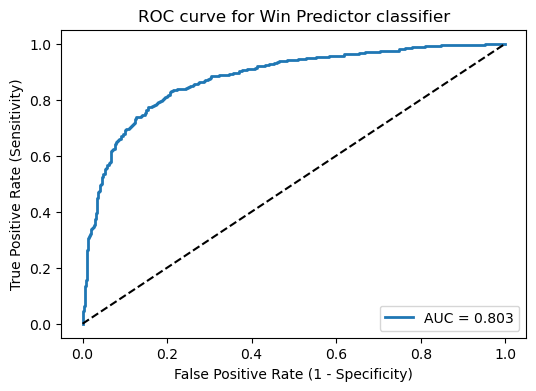

In [ ]:
# calculate the probabilities of a win predicted by logreg100
y_pred_prob = logreg100.predict_proba(X_test)[::,1]

# calculate ROC Curve and AUC
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)

auc = metrics.roc_auc_score(y_test, y_pred)

# Plot ROC Curve
plt.figure(figsize = (6,4))
plt.plot(fpr, tpr, linewidth = 2, label ="AUC = "+str(round(auc, 3)))
plt.plot([0,1], [0,1], 'k--')

plt.title('ROC curve for Win Predictor classifier')
plt.legend(loc = 4)
plt.xlabel('False Positive Rate (1 - Specificity)')

plt.ylabel('True Positive Rate (Sensitivity)')

plt.show()